In [183]:
import numpy as np
import matplotlib.pyplot as plt

class TreeNode(object):
    """Base class for linear models."""

    def __init__(self, feature, value, left=None, right=None):
        """
        Args:
            feature: split on the feature
            value: feature value to split on
            left: left branch, could be numeric values, vectors, or other trees 
            right: right branch, could be numeric values, vectors, or other trees 
        """
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        

def load_dataset(file_path):
    """Load data from file and convert to ndarray."""
    dataset = np.loadtxt(file_path, dtype=float, delimiter='\t')
    return dataset

def binary_split(dataset, feature, value):
    """Binary split the input dataset on given feature and its value.
    
    Args:
        dataset: ndarray of inputs. Shape (m, n)
        feature: split on the feature
        value: feature value to split on
    Returns:
        right: right branch
        left: left branch
    """
    left = dataset[dataset[:, feature] > value]
    right = dataset[dataset[:, feature] <= value]
    return left, right

def build_tree(dataset, get_leaf=get_leaf_node, err_calc=calculate_total_variance, ops=(1, 4)):
    """Build a regression tree using binary split.

    Args:
        dataset: ndarray of inputs. Shape (m, n)
        ops: tuple of parameters for building tree
    Returns:
        tree_node: the root node of the regression tree
    """
    feature, value = select_best_split(dataset, get_leaf, err_calc, ops)
   
    # Return leaf value if stopping condition met
    if feature == None:
        return value
    
    tree_node = TreeNode(feature, value)
    left, right = binary_split(dataset, feature, value)
    tree_node.left = build_tree(left, get_leaf, err_calc, ops)
    tree_node.right = build_tree(right, get_leaf, err_calc, ops)
    
    return tree_node

def select_best_split(dataset, get_leaf, err_calc, ops):
    """Select the best split given a dataset. If stopping condition met, return a leaf node.

    Args:
        dataset: ndarray of inputs. Shape (m, n)
        ops: tuple of parameters for stopping condition. (tolerance on error reduction, min examples for a split)
    Returns:
        feature: index for best splitting feature. If leaf node, return None.
        value: best feature value to split on. If leaf node, return leaf value.
    """
    # Return leaf when all examples in dataset are the same
    if len(set(dataset[:, -1])) <= 1:
        return None, get_leaf(dataset)

    min_loss = ops[0]
    min_instances = ops[1]
    
    m, n = dataset.shape
    best_feature = 0
    best_value = 0 
    best_err = float('inf')
    prior_err = err_calc(dataset)

    for i in range(n - 1):
        for val in set(dataset[:, i]):
            left, right = binary_split(dataset, i, val)
        
            if left.shape[0] < min_instances or right.shape[0] < min_instances:
                continue

            err = err_calc(left) + err_calc(right)
            if err < best_err:
                best_err = err
                best_feature = i
                best_value = val
    # Return leaf node when total information loss is too low
    if (prior_err - best_err) < min_loss:
        return None, get_leaf(dataset)

    left, right = binary_split(dataset, best_feature, best_value)
    # Return leaf node when total num of instances too small
    if left.shape[0] < min_instances or right.shape[0] < min_instances:
        return None, get_leaf(dataset)
    
    return best_feature, best_value


def get_leaf_node(dataset):
    """Calculate the mean value for dataset if it's a leaf node."""
    return np.mean(dataset[:, -1])

def calculate_total_variance(dataset):
    """Calculate the total variance of dataset as a branch."""
    return np.var(dataset[:, -1]) * dataset.shape[0]

def is_tree(obj):
    """Return True if object is a TreeNode, false if otherwise, i.e. leaf node"""
    return type(obj).__name__ == 'TreeNode'

def merge_tree(tree):
    """Merge the left and right branches of the tree and return merged mean value."""
    if is_tree(tree.left):
        tree.left = merge_tree(tree.left)
    if is_tree(tree.right):
        tree.right = merge_tree(tree.right)
    return (tree.left + tree.right) / 2

def prune_tree(tree, testset):
    """Prune the tree based on test set.
    
    Args:
        tree: a TreeNode object
        testset: ndarray of test set. Shape (m', n)
    Returns:
        pruned_tree: a TreeNode object
    """
    # Collapse tree if no test data for this branch
    if testset.shape[0] == 0: 
        return merge_tree(tree)
    
    test_left, test_right = binary_split(testset, tree.feature, tree.value)
    
    if is_tree(tree.left) or is_tree(tree.right):    
        if is_tree(tree.left):
            tree.left = prune_tree(tree.left, test_left)
        if is_tree(tree.right):
            tree.right = prune_tree(tree.right, test_right)
    else: 
        err_no_merge = ((test_left[:, -1] - tree.left) ** 2).sum() + ((test_right[:, -1] - tree.right) ** 2).sum()

        tree_mean = (tree.left + tree.right) / 2
        err_merge = ((testset[:, -1] - tree_mean) ** 2).sum()

        if err_merge < err_no_merge:
            print('merging')
            return tree_mean
        else:
            return tree
    return tree


########################### Model Tree ##############################


def linear_regression(dataset):
    """Calculate the linear regression parameters for dataset."""
    m, n = dataset.shape
    x = np.ones((m, n))
    x[:, 1:] = dataset[:, :n-1]
    y = dataset[:, -1]

    X_sq = x.T.dot(x)
    if np.linalg.det(X_sq) == 0.0:
        print('This is a singular matrix, cannot be inversed.')
        return
    else:
        theta = np.linalg.inv(X_sq).dot(x.T).dot(y)
        return theta, x, y

def linear_leaf(dataset):
    """Obtain the linear regression parameters for dataset 
        when it's a linear model at leaf node.
    """
    theta, x, y = linear_regression(dataset)
    return theta

def calculate_linear_model_error(dataset):
    """Function to calculate the RSS of linear model."""
    theta, x, y = linear_regression(dataset)
    y_pred = x.dot(theta)
    return ((y_pred - y) ** 2).sum()


def tree_predict(tree, x, eval_type='CART'):
    """Predict the y value given x based on regression tree or model tree.
    
    Args:
        tree: the tree built on training set
        x: a test example
        eval_type: 'CART' regression tree, 'model' model tree
    Returns:
        y_pred: a float number of prediction
    """
    if not is_tree(tree):
        if eval_type == 'CART':
            return tree
        elif eval_type == 'model':
            return x.dot(tree[1:]) + tree[0]

    if x[tree.feature] > tree.value:    # x falls into left branch
        return tree_predict(tree.left, x, eval_type)
    else:
        return tree_predict(tree.right, x, eval_type)

def predict(tree, testset, eval_type='CART'):
    """Predict the y values given test set.

    Args:
        tree: the tree built on training set
        testset: ndarray of test set
        eval_type: 'CART' regression tree, 'model' model tree
    Returns:
        y_pred: array of predictions
    """
    m, n = testset.shape
    y_pred = np.zeros(m)

    for i in range(m):
        y_pred[i] = tree_predict(tree, testset[i, :-1], eval_type)
    
    return y_pred

<function get_leaf_node at 0x000001890A44CC18>
<function get_leaf_node at 0x000001890A44CC18>
<function get_leaf_node at 0x000001890A44CC18>
<function get_leaf_node at 0x000001890A44CC18>
<function get_leaf_node at 0x000001890A44CC18>


(-1.0, 2.0)

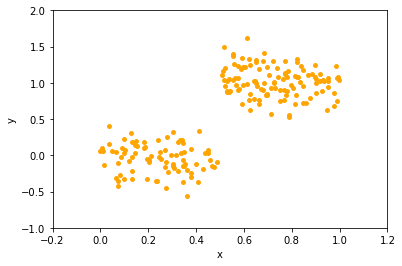

In [160]:
dataset = load_dataset('./data/ex00.txt')
tree = build_tree(dataset, get_leaf_node, calculate_total_variance, (1, 4))

figure = plt.figure()
plt.scatter(dataset[:, 0], dataset[:, 1], c='orange', s=15)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.2, 1.2)
plt.ylim(-1.0, 2.0)

(-1.0, 5.0)

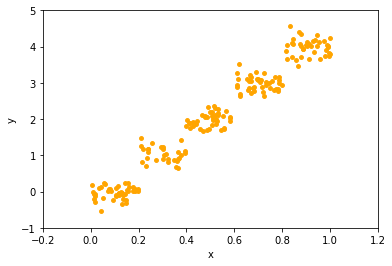

In [163]:
dataset = load_dataset('./data/ex0.txt')
tree = build_tree(dataset)
type(tree).__name__
figure = plt.figure()
plt.scatter(dataset[:, 1], dataset[:, -1], c='orange', s=15)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.2, 1.2)
plt.ylim(-1.0, 5.0)

In [164]:
dataset = load_dataset('./data/ex2.txt')
tree = build_tree(dataset, ops=(0, 1))
test = load_dataset('./data/ex2test.txt')
pruned_tree = prune_tree(tree, test)

merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging


In [175]:
dat4 = load_dataset('./data/exp2.txt')
tree4 = build_tree(dat4, get_leaf=linear_leaf, err_calc=calculate_linear_model_error, ops=(1, 10))

array([1.69855694e-03, 1.19647739e+01])

In [184]:
train = load_dataset('./data/bikeSpeedVsIq_train.txt')
test = load_dataset('./data/bikeSpeedVsIq_test.txt')

tree_reg = build_tree(train, get_leaf_node, calculate_total_variance, ops=(1, 20))
tree_model = build_tree(train, linear_leaf, calculate_linear_model_error, ops=(1, 20))

y_pred_regtree = predict(tree_reg, test, 'CART')
y_pred_modeltree = predict(tree_model, test, 'model')

In [189]:
np.corrcoef(y_pred_regtree, test[:, -1])[0, 1]
np.corrcoef(y_pred_modeltree, test[:, -1])[0, 1]

0.9760412191380607